<a href="https://colab.research.google.com/github/harshaler/Time-Series/blob/master/Time_Series_Forecasting_Methods_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting - Air Passengers

## 1. Study Motivation

The purpose of this exercise is to go through various time series forecasting methods:
    1. Naive
    2. Moving Average
    3. Autoregression
    4. ARIMA
    5. SARIMA
    6. SARIMAX
    7. Single Exponential Smoothing
    8. Holts Winter Exponential Smoothing
    9. Machine Learning - k-Nearest Neighbour Regression (KNN)
    9. Machine Learning - Random Forest Regression
    10. Deep Learning - Recurrent Neural Network (RNN)
    11. Deep Learning - Long Short-Term Memory (LSTM)
***
The list above comprises of both classical and deep learning methodologies for forecasting. 
Machine learning and deep learning methods are often reported to be the key solution to
all predictive modeling problems.

So, we will also evaluate all these models on performance and try to see if deep learning algorithms really outperform classical methods or not.

Dataset we'll be using is for **univariate time series forecasting**. This means that is there is only one variable and there are no additional dependent variables

## 2. Time Series Dataset

Lets look at the data first:

2016-01-06 00:00:00 2019-12-30 00:00:00

No. of rows and columns:  (209,)
                 Sales
Order Date            
2016-01-10  900.829333
2016-01-17  269.735750
2016-01-24  540.076000
2016-01-31  280.288667
2016-02-07  781.548565

This is how our data looks like: 



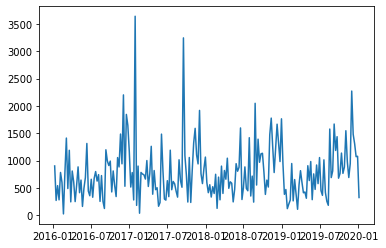

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 

df_excel = pd.read_excel("Sample - Superstore.xls")
furniture = df_excel.loc[df_excel['Category'] == 'Furniture']
print(furniture['Order Date'].min(), furniture['Order Date'].max())

furniture = furniture[['Order Date','Sales']]
furniture.isnull().sum()

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
df = furniture.set_index('Order Date')
df.tail()
df=df['Sales'].resample('W').mean()


# df = pd.read_csv("AirPassengers.csv",index_col='Month')
# print("\nRaw data from csv file: \n",df.tail(10))
# # print(data.index)

# # Converting date into proper format: YYYY-MM to YYYY-MM-DD
# df.index = pd.to_datetime(df.index, format="%Y-%m")

# print("\nAfter Date Format Conversion:\n",df.tail(10))
# #print(data.index)
print("\nNo. of rows and columns: ", df.shape)

df[df.isnull()]=df.mean()
df=df.to_frame()
print(df.head())
#df=df.set_index('Order Date')
print("\nThis is how our data looks like: \n")
plt.plot(df)
plt.show()

## 3. Data Transform

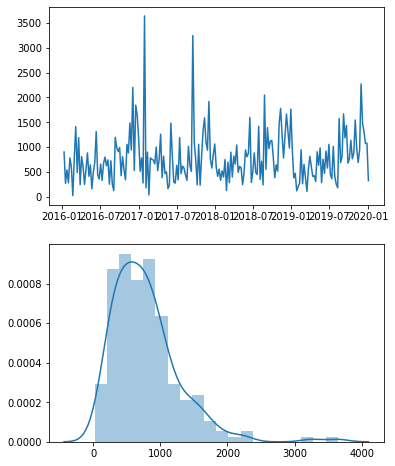

,Sales
Order Date,
2016-01-10,900.829333
2016-01-17,269.735750
2016-01-24,540.076000
2016-01-31,280.288667
2016-02-07,781.548565


In [0]:
plt.figure(figsize=[6,8])
# line plot
plt.subplot(211)
plt.plot(df)
# histogram
plt.subplot(212)
sns.distplot(df)
plt.show()
df.head()

In [0]:
# function to check mean, variability, seasonality, trend in the data series
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

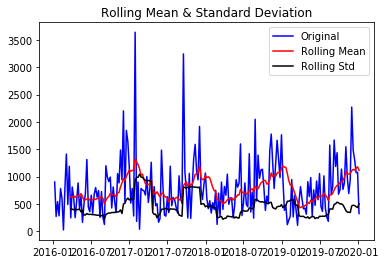

In [0]:
test_stationarity(df)

The dataset is non-stationary, meaning that the mean and the variance of the observations change over time. This makes it difficult to model by both classical statistical methods, like ARIMA, and more sophisticated machine learning methods, like neural networks.

This is caused by what appears to be both an increasing trend and a seasonality component.

In addition, the amount of change, or the variance, is increasing with time. This is clear when you look at the size of the seasonal component and notice that from one cycle to the next, the amplitude (from bottom to top of the cycle) is increasing.

**Original data** will not give us proper results

#### Box-Cox Transformation

If the data show variation that increases or decreases with the level of the series, then a transformation can be useful.

For example, a logarithmic or power transformation (squareroot, cube root) is often useful.


A useful family of transformations, that includes both logarithms and power transformations, is the family of __Box-Cox transformations__

Lambda: 0.315346


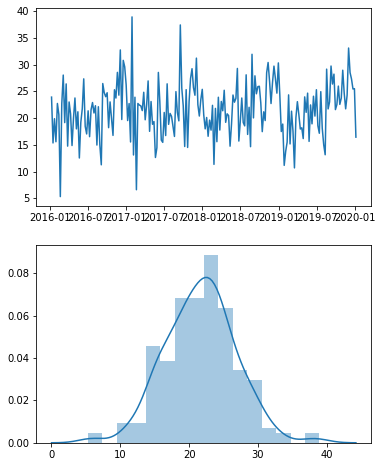

In [0]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

df_bxcx = df.copy()

df_bxcx['Sales'], lam = boxcox(df['Sales'])
print('Lambda: %f' % lam)
plt.figure(figsize=[6,8])
# line plot
plt.subplot(211)
plt.plot(df_bxcx)
# histogram
plt.subplot(212)
sns.distplot(df_bxcx)
plt.show()

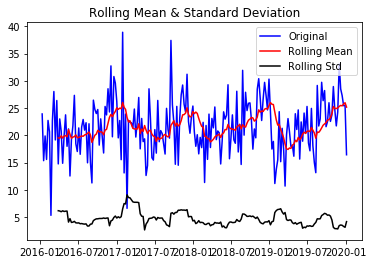

In [0]:
test_stationarity(df_bxcx)
data=df_bxcx.values

We will use this data series for our further analysis.
We may need to deseasonalize or detrend the data but that would depend on our modelling approach.

For now now this transformation is enough to move forward.

## Simple Forecasting

It is important and useful to test simple forecast strategies prior to testing more complex models.
Simple forecast strategies are those that assume little or nothing about the nature of the forecast
problem and are fast to implement and calculate. 
1. Persistent ( use the latest historical value as predicted )
2. Average ( use average of last n historical values )
3. Median ( use median of last n historical values )

But first let us define our model setup.
We'll use __walk forward validation__ for univariate data. This means that the outsome of time-step 1 will be used to predict time-step 2. So, we'll update our history with latest prection to predict the next outcome.

In [0]:
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

In [0]:
def walk_forward_simple(data, n_test, cfg,graph=0):
    predictions = []
    train, test = train_test_split(data, n_test)     # split dataset
    history = [x for x in train] # seed history with training dataset
    
    for i in range(len(test)): # step over each time-step in the test set
        yhat = simple_forecast(history, cfg) # fit model and make forecast for history
        predictions.append(yhat) # store forecast in list of predictions
        history.append(yhat) # add predicted observation to history for the next loop
        #print(history)
    rmse = sqrt(mean_squared_error(test, predictions))  # estimate prediction error
    mape = mean_absolute_percentage_error(test, predictions)
    if graph == 1:
        predicted = [None]*len(train)
        predicted.extend(predictions)
        test2 = [None]*len(train)
        test2.extend(test)
        
        title =' Model %s ; RMSE : %.3f MAPE: %.3f %%' % (cfg, rmse,mape)
        plt.plot(train, c='b', label="Historical")
        plt.plot(test2, c='g',label ="Actual")
        plt.plot(predicted, c='orange', label = "Prediction")
        plt.legend(loc="upper left")
        plt.title(title)
        plt.show()
    
    key = str(cfg)
    return (key, rmse,mape,predictions)

In [0]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [0]:
def mean_absolute_percentage_error(test, pred):
    y_true, y_pred = np.array(test), np.array(pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def simple_forecast(history, config):
    n, offset, avg_type = config
    
    if avg_type == 'persist': # persist value, ignore other config
        return history[-n]
    
    values = list() # collect values to average

    for i in range(1, n+1): # try and collect n values using offset
        ix = i * offset
        values.append(history[-ix])
   
    if avg_type == 'mean':
        return mean(values)
    
    # median of last n values
    return median(values)

Now we can visualize how our models look like and explain what we observe

__1. Last actual value is the predicted value__

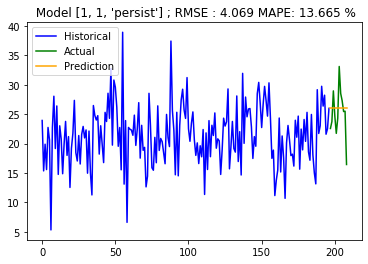

13.665394703330277


In [0]:
n_test=12
result = walk_forward_simple(data, n_test, [1,1,'persist'],1)
print(result[2])

__2. Take mean of last 12 months actuals__

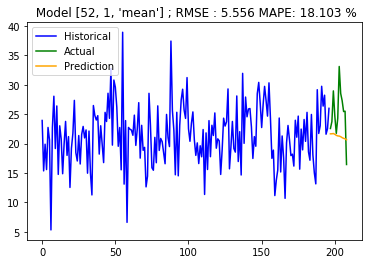

In [0]:
result = walk_forward_simple(data, n_test, [52,1,'mean'],1)

__3. Take actual of last year__

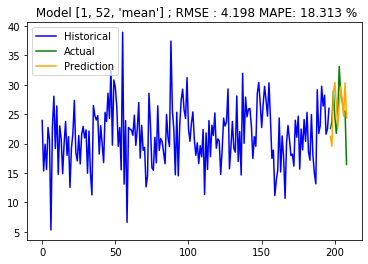

In [0]:
result = walk_forward_simple(data, n_test, [1,52,'mean'],1)

__4. Take mean of last few years__

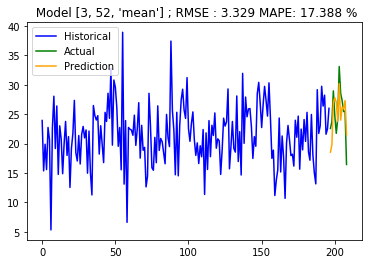

In [0]:
result = walk_forward_simple(data, n_test, [3,52,'mean'],1)

__5. Take median of last few years__

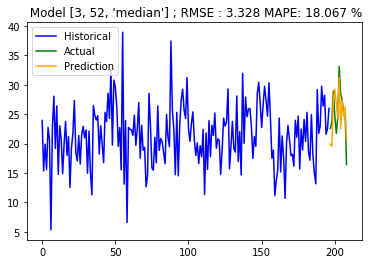

In [0]:
result = walk_forward_simple(data, n_test, [3,52,'median'],1)

## SARIMA Model

Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting
methods for univariate time series data forecasting. Although the method can handle data
with a trend, it does not support time series with a seasonal component. An extension to
ARIMA that supports the direct modeling of the seasonal component of the series is called
SARIMA. 

In this section, we will discover the Seasonal Autoregressive Integrated Moving
Average, or SARIMA, method for time series forecasting with univariate data containing trends
and seasonality.

In [0]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv

In [0]:
def walk_forward_sarima(data, n_test, cfg,graph=0):
    predictions = []
    
    train, test = train_test_split(data, n_test) # split dataset
    history = train.tolist() # seed history with training dataset
    #print("test",test.tolist())
    #print("history",history)
    for i in range(len(test)): # step over each time-step in the test set
        #print(i)
        yhat = sarima_forecast(history, cfg) # fit model and make forecast for history
        predictions.append(yhat) # store forecast in list of predictions
        #print(predictions)
        history.append(yhat) # add actual observation to history for the next loop
        #print(history)
    rmse = sqrt(mean_squared_error(test, predictions))  # estimate prediction error
    mape = mean_absolute_percentage_error(test, predictions)
    print(' Model %s ; RMSE : %.3f MAPE: %.3f %%' % (cfg, rmse,mape))
    
    if graph == 1:
        predicted = [None]*len(train)
        predicted.extend(predictions)
        test2 = [None]*len(train)
        test2.extend(test)
        
        title =' Model %s ; RMSE : %.3f MAPE: %.3f %%' % (cfg, rmse,mape)
        plt.plot(train, c='b', label="Historical")
        plt.plot(test2, c='g',label ="Actual")
        plt.plot(predicted, c='orange', label = "Prediction")
        plt.legend(loc="upper left")
        plt.title(title)
        plt.show()
        
    key = str(cfg)
    return (key,rmse,mape,predictions)

In [0]:
def mean_absolute_percentage_error(test, pred):
    y_true, y_pred = np.array(test), np.array(pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def sarima_forecast(history, config):
    order, sorder, trend = config
    
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
                    enforce_stationarity=False, enforce_invertibility=False) # define model
    
    model_fit = model.fit(disp=False) # fit model
    
    yhat = model_fit.predict(len(history), len(history)) # make one step forecast
    #print(yhat)
    return yhat

In [0]:
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0,1]
    d_params = [0,1]
    q_params = [0,1]
    t_params = ['n','t','c','ct']
    P_params = [0,1]
    D_params = [0,1]
    Q_params = [0,1]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

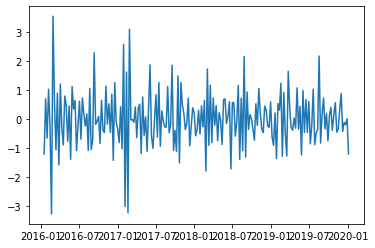

In [0]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

df_log=np.log(df)
data2 = df_log - df_log.shift()
data2.dropna(inplace=True)
plt.plot(data2)
plt.show()

C:\Users\harsh\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


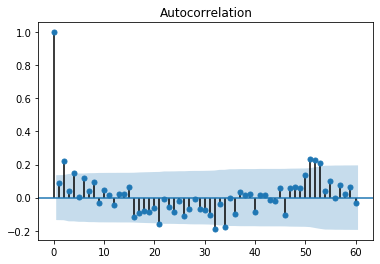

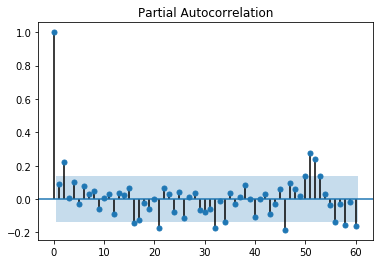

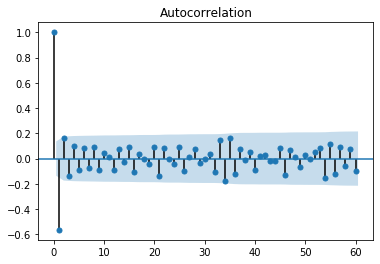

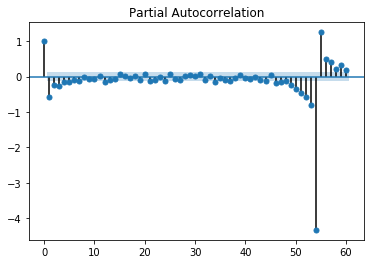

In [0]:
plot_acf(df_bxcx,lags=60)
plot_pacf(df_bxcx,lags=60)
plot_acf(data2,lags=60)
plot_pacf(data2,lags=60)
plt.show()
plt.show()


In [0]:
print(data.dtype)
n_test=12
p=0
d=0
q=0
P=1
D=1
Q=0
m=12
t= 't'
cfg = [(p,d,q), (P,D,Q,m), t]
#print(data)
cfg_list = sarima_configs(seasonal=[52])
try:
    # never show warnings when grid searching, too noisy
    with catch_warnings():
        filterwarnings("ignore")
        scores = [walk_forward_sarima(data, n_test, cfg,0) for cfg in cfg_list]
except:
    error = None

#result = walk_forward_sarima(data, n_test, cfg ,1)

float64
 Model [(0, 0, 0), (0, 0, 0, 52), 'n'] ; RMSE : 25.507 MAPE: 100.000 %
 Model [(0, 0, 0), (0, 0, 1, 52), 'n'] ; RMSE : 25.507 MAPE: 100.000 %
 Model [(0, 0, 0), (0, 1, 0, 52), 'n'] ; RMSE : 4.198 MAPE: 14.414 %
 Model [(0, 0, 0), (0, 1, 1, 52), 'n'] ; RMSE : 3.348 MAPE: 12.533 %
 Model [(0, 0, 0), (1, 0, 0, 52), 'n'] ; RMSE : 4.066 MAPE: 14.451 %
 Model [(0, 0, 0), (1, 0, 1, 52), 'n'] ; RMSE : 4.259 MAPE: 15.914 %
 Model [(0, 0, 0), (1, 1, 0, 52), 'n'] ; RMSE : 3.630 MAPE: 13.728 %
 Model [(0, 0, 0), (1, 1, 1, 52), 'n'] ; RMSE : 3.814 MAPE: 14.092 %
 Model [(0, 0, 0), (0, 0, 0, 52), 't'] ; RMSE : 9.223 MAPE: 36.674 %
 Model [(0, 0, 0), (0, 0, 1, 52), 't'] ; RMSE : 9.056 MAPE: 35.917 %
 Model [(0, 0, 0), (0, 1, 0, 52), 't'] ; RMSE : 4.225 MAPE: 14.446 %
 Model [(0, 0, 0), (0, 1, 1, 52), 't'] ; RMSE : 3.352 MAPE: 12.458 %
 Model [(0, 0, 0), (1, 0, 0, 52), 't'] ; RMSE : 4.519 MAPE: 15.229 %
 Model [(0, 0, 0), (1, 0, 1, 52), 't'] ; RMSE : 42.471 MAPE: 171.386 %
 Model [(0, 0, 0), (

 Model [(0, 1, 1), (1, 1, 0, 52), 'c'] ; RMSE : 3.628 MAPE: 13.698 %
 Model [(0, 1, 1), (1, 1, 1, 52), 'c'] ; RMSE : 3.869 MAPE: 14.616 %
 Model [(0, 1, 1), (0, 0, 0, 52), 'ct'] ; RMSE : 5.194 MAPE: 16.407 %
 Model [(0, 1, 1), (0, 0, 1, 52), 'ct'] ; RMSE : 4.038 MAPE: 12.039 %
 Model [(0, 1, 1), (0, 1, 0, 52), 'ct'] ; RMSE : 4.103 MAPE: 14.291 %
 Model [(0, 1, 1), (0, 1, 1, 52), 'ct'] ; RMSE : 3.539 MAPE: 13.426 %
 Model [(0, 1, 1), (1, 0, 0, 52), 'ct'] ; RMSE : 5.018 MAPE: 16.496 %
 Model [(0, 1, 1), (1, 0, 1, 52), 'ct'] ; RMSE : 4.104 MAPE: 12.364 %
 Model [(0, 1, 1), (1, 1, 0, 52), 'ct'] ; RMSE : 3.917 MAPE: 13.562 %
 Model [(0, 1, 1), (1, 1, 1, 52), 'ct'] ; RMSE : 4.793 MAPE: 16.291 %
 Model [(1, 0, 0), (0, 0, 0, 52), 'n'] ; RMSE : 8.119 MAPE: 24.985 %
 Model [(1, 0, 0), (0, 0, 1, 52), 'n'] ; RMSE : 8.119 MAPE: 24.985 %
 Model [(1, 0, 0), (0, 1, 0, 52), 'n'] ; RMSE : 4.316 MAPE: 15.318 %
 Model [(1, 0, 0), (0, 1, 1, 52), 'n'] ; RMSE : 3.511 MAPE: 13.146 %
 Model [(1, 0, 0), (1, 0, 

In [0]:
scores.sort(key=lambda tup: tup[1])
for cfg, error,p in scores:
    print(cfg, error)